In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error # pour importer la fonction de la MAE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import numpy as np


data = pd.read_pickle("Création du Dataset/dataset.pkl")

## Preprocess des données

In [3]:
#suppression des KDA car bcp de 0
roles = ["TOP","JGL","MID","ADC","SUP"]
colomnes = []
for i in [0,1]:
    for role in roles :
        colomnes.append(f"{role}{i}_KDA")
# print(colomnes)
data = data.drop(columns = colomnes)

#----------------------------------------------

# suppression des listes pour le KDAG par transformation en plusieurs colomnes
colomnes_KDAG=[]
for colomne in colomnes:
    colomnes_KDAG.append(colomne + "G")
# print(colomnes_KDAG)

for colomne in colomnes_KDAG:
    nom = colomne[:-4]
    data2 = pd.DataFrame(data[f"{colomne}"].to_list(),data.index,columns=[f"{nom}K",f"{nom}D",f"{nom}A",])
    data[f'{nom}KDA_Ratio'] = (data2[f'{nom}K'] + data2[f'{nom}A']) / (data2[f'{nom}D']+1)
    data = data.drop(columns = colomne)
# print(data)

#----------------------------------------------

#champion par leur ID :
dict_champ = {}
L=['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'AurelionSol', 'Azir', 'Bard', 'Belveth', 'Blitzcrank', 'Brand', 'Braum', 'Caitlyn', 'Camille', 'Cassiopeia', 'Chogath', 'Corki', 'Darius', 'Diana', 'Draven', 'DrMundo', 'Ekko', 'Elise', 'Evelynn', 'Ezreal', 'FiddleSticks', 'Fiora', 'Fizz', 'Galio', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Graves', 'Gwen', 'Hecarim', 'Heimerdinger', 'Illaoi', 'Irelia', 'Ivern', 'Janna', 'JarvanIV', 'Jax', 'Jayce', 'Jhin', 'Jinx', 'Kaisa', 'Kalista', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kayle', 'Kayn', 'Kennen', 'Khazix', 'Kindred', 'Kled', 'KogMaw','KSante', 'Leblanc', 'LeeSin', 'Leona', 'Lillia', 'Lissandra', 'Lucian', 'Lulu', 'Lux', 'Malphite', 'Malzahar', 'Maokai', 'MasterYi', 'MissFortune', 'MonkeyKing', 'Mordekaiser', 'Morgana', 'Nami', 'Nasus', 'Nautilus', 'Neeko', 'Nidalee', 'Nilah', 'Nocturne', 'Nunu', 'Olaf', 'Orianna', 'Ornn', 'Pantheon', 'Poppy', 'Pyke', 'Qiyana', 'Quinn', 'Rakan', 'Rammus', 'RekSai', 'Rell', 'Renata', 'Renekton', 'Rengar', 'Riven', 'Rumble', 'Ryze', 'Samira', 'Sejuani', 'Senna', 'Seraphine', 'Sett', 'Shaco', 'Shen', 'Shyvana', 'Singed', 'Sion', 'Sivir', 'Skarner', 'Sona', 'Soraka', 'Swain', 'Sylas', 'Syndra', 'TahmKench', 'Taliyah', 'Talon', 'Taric', 'Teemo', 'Thresh', 'Tristana', 'Trundle', 'Tryndamere', 'TwistedFate', 'Twitch', 'Udyr', 'Urgot', 'Varus', 'Vayne', 'Veigar', 'Velkoz', 'Vex', 'Vi', 'Viego', 'Viktor', 'Vladimir', 'Volibear', 'Warwick', 'Xayah', 'Xerath', 'XinZhao', 'Yasuo', 'Yone', 'Yorick', 'Yuumi', 'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean', 'Zoe', 'Zyra']
for i in range(len(L)):
    dict_champ[L[i]]=i

def ID_champ(L):
    return(dict_champ[L])

for colomne in colomnes:
    nom = colomne[:-3]
    data[f"{nom}CHAMP"] = data[f"{nom}CHAMP"].apply(ID_champ)

# On s'occupe du rank (voir Paul) :
def elo(L):
    if L[0]=="IRON":
        e = 0
    elif L[0]=="BRONZE":
        e = 400
    elif L[0]=="SILVER":
        e = 800
    elif L[0]=="GOLD":
        e = 1200
    elif L[0]=="PLATINUM":
        e = 1600
    elif L[0]=="DIAMOND":
        e = 2000
    else:
        e = 2300
    if L[1] == 'III':
        e += 100
    elif L[1] == 'II':
        e += 200
    elif L[1] == 'I':
        e += 300
    return e + L[2]

for c in data.columns:
    if c[-4:] == "RANK":
        data[c] = data[c].apply(elo)


# Pour l'ensemble des rôles, ajout d'un ratio sur le LVL entre les joueurs de l'équipe 1 et 2 correspondants
for role in roles:
    data[f"{role}_LVL_RATIO"]=data[f"{role}0_LVL"]/data[f"{role}1_LVL"]
data["LVL_RATIO_MEAN"]=(data["SUP0_LVL"]+data["ADC0_LVL"]+data["MID0_LVL"]+data["JGL0_LVL"]+data["TOP0_LVL"])/(data["SUP1_LVL"]+data["ADC1_LVL"]+data["MID1_LVL"]+data["JGL1_LVL"]+data["TOP1_LVL"])

# Ajout d'un ratio de win streak : si +4 : 4 joueurs de plus en winstreak dans l'équipe 1 que dans l'équipe 2. Prend des valeurs entre -5 et 5
data["RATIO_WINSTREAK"]=data["SUP0_HOT"]*1+data["ADC0_HOT"]*1+data["MID0_HOT"]*1+data["JGL0_HOT"]*1+data["TOP0_HOT"]*1-(data["SUP1_HOT"]*1+data["ADC1_HOT"]*1+data["MID1_HOT"]*1+data["JGL1_HOT"]*1+data["TOP1_HOT"]*1)

#graphe rapide pour voir la répartition des victoires pour l'équipe 1 en fonction du ratio de winstreak
df2 = data.groupby(['RATIO_WINSTREAK','Y'])['Y'].count().reset_index(name="nb_victoires") # on récupère les ratios pour les analyser
df3 = df2[df2.Y==True]
# plt.bar(df3.RATIO_WINSTREAK,df3.nb_victoires)
# plt.show()

C:\Users\maila\AppData\Local\Temp\ipykernel_6176\2141149592.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{nom}KDA_Ratio'] = (data2[f'{nom}K'] + data2[f'{nom}A']) / (data2[f'{nom}D']+1)
C:\Users\maila\AppData\Local\Temp\ipykernel_6176\2141149592.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{nom}KDA_Ratio'] = (data2[f'{nom}K'] + data2[f'{nom}A']) / (data2[f'{nom}D']+1)
C:\Users\maila\AppData\Local\Temp\ipykernel_6176\2141149592.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

## Fonction de calcul des MI scores

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

## RandomForestClassifier

In [8]:
y = data["Y"].astype(int) # pour avoir des 0 et des 1 au lieu de True et False
X=data.drop(columns = ["Y"])
scores = []
N = 10
for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=600,n_jobs=6)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test,y_test))
print(f"Moyenne des scores sur {N} modèles: {sum(scores)/len(scores)}")

Moyenne des scores sur 10 modèles: 0.6137254901960784


### Graphe de l'importance des features dans le modèle

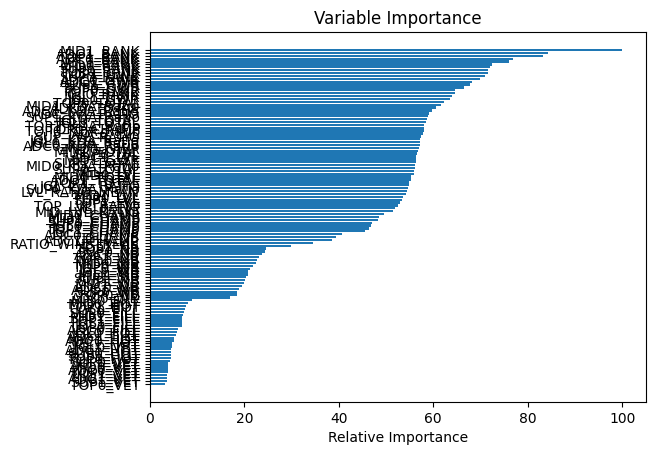

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = RandomForestClassifier(n_estimators=600,n_jobs=6)
clf.fit(X_train, y_train)

importance = clf.feature_importances_

f_importance = 100.0 * (importance / importance.max())
sorted_idx = np.argsort(f_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, f_importance[sorted_idx], align='center')
plt.yticks(pos, [X_train.columns[u] for u in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## XGBClassifier

In [4]:
from xgboost import XGBClassifier

def pourcentage_reussite(X,y):
    Z = np.where(X== y,1,0)
    return(Z.sum()/(Z.shape[0])*100)

y = data["Y"].astype(int) # pour avoir des 0 et des 1 au lieu de True et False
X=data.drop(columns = ["Y"])
scores = []
N = 7
max= (0,0,0)
for number_of_trees in range(100,1100,100): #recherche de la meilleure profondeur
    for learning_r in range(1,12): #recherche du meilleur learning rate
        for i in range(N):
            train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)
            modele = XGBClassifier(n_estimators = number_of_trees, learning_rate=learning_r/20, n_jobs=6)
            modele.fit(train_X, train_y, 
                    early_stopping_rounds=5, #si l'erreur se détériore sur 5 cycles on arrête le programme même si < n_estimators
                    eval_set=[(val_X, val_y)], #obligatoire quand early_stopping_rounds utilisé
                    verbose=False)
            donnees_predites = modele.predict(val_X)
            scores.append(pourcentage_reussite(donnees_predites,val_y))
        moyenne = sum(scores)/len(scores)
        if moyenne>max[0]:
            max=(moyenne,number_of_trees,learning_r/20)

c:\Users\maila\anaconda3\envs\Projet\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


### Importances des vaariables

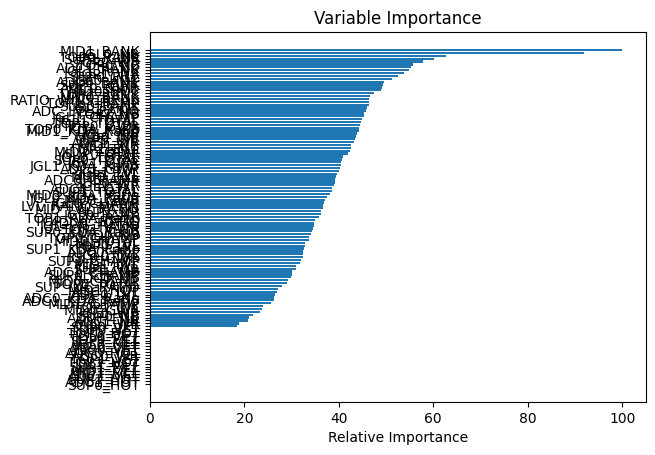

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
modele = XGBClassifier(n_estimators = max[1], learning_rate=max[2]/20, n_jobs=-1)
modele.fit(X_train, y_train)

importance = modele.feature_importances_

f_importance = 100.0 * (importance / importance.max())
sorted_idx = np.argsort(f_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, f_importance[sorted_idx], align='center')
plt.yticks(pos, [X_train.columns[u] for u in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Tentative de clustering

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
kmeans = KMeans(n_clusters=3)
X=data.loc[:, ["TOP0_LVL","TOP1_LVL"]]
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")
sns.relplot(x="TOP0_LVL", y="TOP1_LVL", hue="Cluster", data=X, height=6)
plt.show()

kmeans = KMeans(n_clusters=5)
X=data.loc[:, ["TOP0_GWR","TOP1_GWR"]]
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")
sns.relplot(x="TOP0_GWR", y="TOP1_GWR", hue="Cluster", data=X, height=6)
plt.show()
print(make_mi_scores(X, y))